In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import cv2
import tensorflow as tf

'''
for dirname, _, filenames in os.walk('/Users/joyceli/Desktop/MECENG249/CNN/figuredata/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        '''
nRowsRead = 500 # specify 'None' if want to read whole file
# Output.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/Users/joyceli/Desktop/MECENG249/CNN/archive/PMdata.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'PMdata.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')
df1 = df1.set_index('fileName')

# Test out how to get the PM25 values for matching later
print(df1.loc['201612200830.jpg']['PM25'])
df1.head(5)


There are 206 rows and 2 columns
342


,PM25
fileName,
201612200830.jpg,342
201612200930.jpg,336
201612201030.jpg,387
201612201130.jpg,341
201612201230.jpg,256


201702261130.jpg


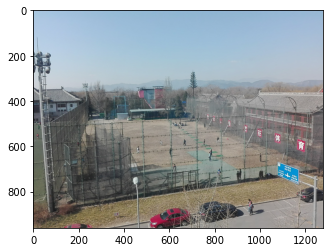

image array: 
 [[[169 193 219]
  [170 194 220]
  [171 195 223]
  ...
  [153 184 213]
  [153 184 213]
  [152 183 212]]

 [[178 202 228]
  [178 202 228]
  [177 201 229]
  ...
  [153 184 213]
  [153 184 213]
  [154 185 214]]

 [[174 200 225]
  [174 200 225]
  [173 199 226]
  ...
  [153 184 213]
  [154 185 214]
  [154 185 214]]

 ...

 [[127  99  75]
  [130 102  78]
  [134 106  82]
  ...
  [162 156 156]
  [163 158 155]
  [163 158 155]]

 [[131 103  82]
  [106  78  57]
  [ 98  70  49]
  ...
  [163 157 157]
  [164 158 158]
  [163 158 155]]

 [[136 107  91]
  [118  89  73]
  [104  75  59]
  ...
  [163 157 157]
  [165 159 159]
  [164 158 158]]]
image array shape:  (960, 1280, 3)


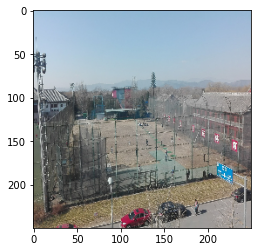

New array shape:  (250, 250, 3)


In [2]:

DATADIR = '/Users/joyceli/Desktop/MECENG249/CNN/'

folder_name = "figuredata"
path = '/Users/joyceli/Desktop/MECENG249/CNN/figuredata'
#path = os.path.join(DATADIR,folder_name)  # create path to the air quality photos
img_array = []
img = os.listdir(path)[0]
print(img)
img_array = cv2.imread(os.path.join(path,img)) #,cv2.IMREAD_COLOR)  # convert to array
img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)


plt.imshow(img_array)  # graph it
plt.show()  # display

print("image array: \n",img_array)
print("image array shape: ",img_array.shape)

#reshape image and pixelate
img_size = 250
new_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
new_array = cv2.resize(img_array, (img_size, img_size))

plt.imshow(new_array)# cmap='gray')
plt.show()

# create the data array for CNNs

Xdata = []
ydata = []

# the PM2.5 readings are stored similar to class numbers in a classification model
for img in os.listdir(path):
    try:
        img_array = cv2.imread(os.path.join(path,img)) #convert the image to an array
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        new_array = cv2.resize(img_array, (img_size, img_size))  # resize to normalize data size
        Xdata.append(new_array)
        ydata.append(df1.loc[str(img)]['PM25'])
    except Exception as e:
            pass 
print("New array shape: ", new_array.shape)

Xdata = np.array(Xdata)
ydata = np.array(ydata)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xdata,ydata, test_size = 0.2, random_state=25)


Text(0.5, 1.0, 'Ground Truth : 34')

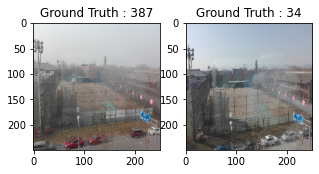

In [4]:
#Source: CNN skeleton code from ME249

plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(X_train[0], cmap='gray')
plt.title("Ground Truth : {}".format(y_train[0]))

# Display the first image in testing data
plt.subplot(122) #For example, "111" means "1x1 grid, first subplot" and "234" means "2x3 grid, 4th subplot".
plt.imshow(X_test[0], cmap='gray')
plt.title("Ground Truth : {}".format(y_test[0]))

In [18]:
#THE NETWORK -NOTE THAT CELLS ABOVE THIS ONE WERE NOT CHANGED AND ARE IDENTICAL TO    <<<<<<<< *******
#             THE CODE FOR THE NON-DROPOUT MODEL

'''The images are of size 28 x 28. You convert the image matrix to an array, 
rescale it between 0 and 1, reshape it so that it's of size 28 x 28 x 1, 
and feed this as an input to the network.
You'll use three convolutional layers:
The first layer will have 32-3 x 3 filters,
The second layer will have 64-3 x 3 filters and
The third layer will have 128-3 x 3 filters.
In addition, there are three max-pooling layers each of size 2 x 2.'''

#First, import all the necessary modules required to train the model.
from tensorflow import keras
from tensorflow.keras.layers import Input
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU, ReLU
from tensorflow.keras import layers

# Adding Dropout into the Network


'''You can add a dropout layer to overcome the problem of overfitting to some extent. Dropout randomly 
turns off a fraction of neurons during the training process, reducing the dependency on the training 
set by some amount. How many fractions of neurons you want to turn off is decided by a hyperparameter, 
which can be tuned accordingly. This way, turning off some neurons will not allow the network to 
memorize the training data since not all the neurons will be active at the same time and the inactive 
neurons will not be able to learn anything.
'''

#same as before:
batch_size = 30
epochs = 100
num_classes = 1

data_augmentation_layer = tf.keras.Sequential([                                    
  tf.keras.layers.RandomFlip('horizontal',
         input_shape=(img_size, img_size, 3)), tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)                              
], name='data_augmentation')



#NEURAL NETWORK ARCHITECTURE

pm25_model = Sequential()
pm25_model.add(data_augmentation_layer)

pm25_model.add(ReLU())
pm25_model.add(MaxPooling2D((2, 2),padding='same'))  #same to here
pm25_model.add(Dropout(0.25)) #added

pm25_model.add(Conv2D(64, (3, 3), activation='relu',padding='same')) # next three the same
pm25_model.add(ReLU())
pm25_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
pm25_model.add(Dropout(0.25)) #added

pm25_model.add(Conv2D(128, (3, 3), activation='relu',padding='same')) # next three the same
pm25_model.add(ReLU())                  
pm25_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
pm25_model.add(Dropout(0.4))  #added

# pm25_model.add(Conv2D(256, (3, 3), activation='relu',padding='same')) # next three the same
# pm25_model.add(LeakyReLU())                  
# pm25_model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
# pm25_model.add(Dropout(0.4))  #added

pm25_model.add(Flatten())                # next three the same
pm25_model.add(Dense(128, activation='relu'))
pm25_model.add(ReLU())  
pm25_model.add(Dropout(0.3))  #added


pm25_model.add(Dense(num_classes))# the same

#BUILT MODEL
#model.build(img_size,img_size,3)

#SUMMARIZE MODEL
'''To visualize the layers that created in the above step, use the summary function. 
This will show some parameters (weights and biases) in each layer and also the total parameters in your model.'''
pm25_model.summary()

#COMPLIE THE MODEL
'''After the model is created, you compile it using the Adam optimizer, one of the 
most popular optimization algorithms. You can read more about this optimizer here. 
Additionally, you specify the loss type which is categorical cross entropy which 
is used for multi-class classification, you can also use binary cross-entropy as 
the loss function. Lastly, you specify the metrics as accuracy which you want to 
analyze while the model is training.'''
pm25_model.compile(loss='mse', optimizer=keras.optimizers.Adam(),metrics=[tf.keras.metrics.MeanSquaredError()])
# add learning rate


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data_augmentation (Sequentia (None, 250, 250, 3)       0         
_________________________________________________________________
re_lu (ReLU)                 (None, 250, 250, 3)       0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 125, 125, 3)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 125, 125, 3)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 125, 125, 64)      1792      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 125, 125, 64)      0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 63, 63, 64)       

In [24]:
#TRAIN THE MODEL
'''It's finally time to train the model with Keras' fit() function! The model trains for 20 epochs. 
The fit() function will return a history object; By storying the result of this function 
in fashion_train, you can use it later to plot the accuracy and loss function plots between 
training and validation which will help you to analyze your model's performance visually.'''
#just changed name here
epochs = 50
from keras import backend as K
K.set_value(pm25_model.optimizer.learning_rate, 0.001)


pm25_train_dropout = pm25_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1)#,validation_data=(X_test, y_test))

'''This added code will save the model so that you can directly load it and not have to train it again 
for 20 epochs. This way, you can load the model later on if you need it and modify the architecture;'''
!mkdir -p saved_model
pm25_model.save('saved_model/pm25_model')
#pm25_model.save("pm25_model_dropout.h5py")

Epoch 1/50
6/6 [==============================] - 6s 884ms/step - loss: 17827052.0000 - mean_squared_error: 17827052.0000
Epoch 2/50
6/6 [==============================] - 5s 892ms/step - loss: 19659224.0000 - mean_squared_error: 19659224.0000
Epoch 3/50
6/6 [==============================] - 5s 893ms/step - loss: 21539936.0000 - mean_squared_error: 21539936.0000
Epoch 4/50
6/6 [==============================] - 5s 855ms/step - loss: 17144064.0000 - mean_squared_error: 17144064.0000
Epoch 5/50
6/6 [==============================] - 5s 865ms/step - loss: 16866854.0000 - mean_squared_error: 16866852.0000
Epoch 6/50
6/6 [==============================] - 5s 861ms/step - loss: 15936727.0000 - mean_squared_error: 15936727.0000
Epoch 7/50
6/6 [==============================] - 5s 870ms/step - loss: 19394058.0000 - mean_squared_error: 19394058.0000
Epoch 8/50
6/6 [==============================] - 5s 875ms/step - loss: 15306899.0000 - mean_squared_error: 15306899.0000
Epoch 9/50
6/6 [========

In [25]:
ypredict = pm25_model.predict(X_test)
dfy = pd.DataFrame(ypredict, y_test)
dfy
#120

,0
34,-1464.377930
7,-1690.767944
3,-1477.528442
77,-31.418051
20,-1253.291382
3,-1007.214417
166,-599.231567
20,-408.050873
5,-921.484558
30,-1209.106689


In [15]:
#mean absolute error
n = len(ypredict)
sum = 0
for i in range(n):
    sum += abs(y_test[i] - ypredict[i])
error = sum/n

# display
print("Mean absolute error : " + str(error))

#mean square error

Mean absolute error : [104.549164]


/Users/joyceli/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  
/Users/joyceli/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  
/Users/joyceli/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  
/Users/joyceli/opt/anaconda3/envs/Python3-7_Keras_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  if __name__ == '__main__':


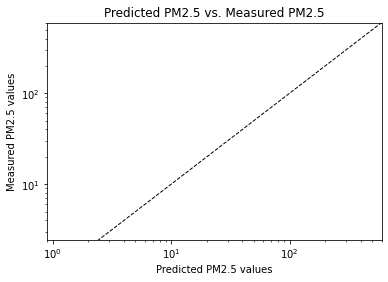

In [16]:
# # Plot log-log plot
plt.scatter(ypredict, y_test)
plt.title('Predicted PM2.5 vs. Measured PM2.5')
plt.xlabel('Predicted PM2.5 values')
plt.ylabel('Measured PM2.5 values')
plt.loglog()
#plt.autoscale()
plt.xlim([0, 600])
plt.ylim([0, 600])
xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=1, scalex=False, scaley=False)

plt.show()